In [82]:
import os, sys
import time
import numpy as np
import pandas as pd
import random

import torch

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [2]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)
        
random_state = np.random.RandomState(2020)

In [3]:
# load functions from another notebook
%run helpers.ipynb

In [4]:
# implicit_model = load_model('implicit_factorization')
lstm_model = load_model(model_type='entire')
pooling_model = load_model('pooling')

In [5]:
class ComputeLoss:
    def __init__(self, target, original_input, top_k=10, weights=[1, 0, 0], total_CFs=1):
        self.target_item = target
        self.top_k = top_k
        self.original_items = original_input
        self.total_CFs = total_CFs
        (self.proximity_weight, self.diversity_weight, self.regularization_weight) = weights
    
    def _compute_yloss(self, target_score, kth_score):
        yloss = 0.0        
        for i in range(self.total_CFs):
#             temp_loss = max(0, target_score/kth_score - 1.0)
            temp_loss = target_score/kth_score

            yloss += temp_loss        
        return yloss/self.total_CFs

    def _compute_dist(self, x_hat, x1):
        """Compute weighted distance between two vectors."""
    #     return sum(abs(x_hat - x1))
#         diff = set(x1).difference(set(x_hat))
        diff = np.setdiff1d(x1, x_hat)
        return len(diff)

    def _compute_proximity_loss(self, cfs):
        proximity_loss = 0.0        
        for i in range(self.total_CFs):        
            proximity_loss += self._compute_dist(cfs, self.original_items)            
        return proximity_loss/np.multiply(len(self.original_items), self.total_CFs)

    def _compute_diversity_loss(self):
        proximity_loss = 0.0
        return proximity_loss/self.total_CFs

    def _compute_regularization_loss(self, x):
        """Adds a linear equality constraints to the loss functions - to ensure all levels of a categorical variable sums to one"""
        regularization_loss = 0.0
        for i in range(self.total_CFs):
            pass
#             for v in self.encoded_categorical_feature_indexes:
#                 regularization_loss += torch.pow((torch.sum(self.cfs[i][v[0]:v[-1]+1]) - 1.0), 2)
#             regularization_loss += max(0, x - 1.0)

        return regularization_loss

    def compute_loss(self, cfs, preds, ranking, total_CFs=1):
        """Computes the overall loss"""
            
        yloss = self._compute_yloss(preds[self.target_item], preds[(ranking == self.top_k).nonzero()])
        proximity_loss = self._compute_proximity_loss(cfs) if self.proximity_weight > 0 else 0.0
        diversity_loss = self._compute_diversity_loss() if self.diversity_weight > 0 else 0.0
        regularization_loss = self._compute_regularization_loss(yloss) if self.regularization_weight > 0 else 0.0

        loss = yloss + (self.proximity_weight * proximity_loss) \
            - (self.diversity_weight * diversity_loss) \
            + (self.regularization_weight * regularization_loss)
        return loss

In [16]:
class BaseStrategy:
    def __init__(self, item, interactions, max_length):
        self.target_item = item
        self.original_interactions = interactions
        self.max_length = max_length
        self.visited_ = set()
        
    def next_comb(self):
        raise NotImplementedError
    
    def _get_pos(self, number):
        bits = []
        for i, c in enumerate(bin(number)[:1:-1], 1):
            if c == '0':
                bits.append(i)
        return bits

In [92]:
class RandomSelection(BaseStrategy):
    def __init__(self, item, interactions, max_sequence_length):
        super().__init__(item, interactions, max_sequence_length)        
    
    def next_comb(self):        
        number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
        while number in self.visited_:            
            number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
#         number = np.random.choice(np.setdiff1d(range(1, pow(2, self.max_length)), self.visited_))
        self.visited_.add(number)
        bits = self._get_pos(number)
        seq = np.delete(self.original_interactions, bits)        
                
        return seq

In [21]:
class MostSimilarSelection(BaseStrategy):
    def __init__(self, item, interactions, max_sequence_length):
        super().__init__(item, interactions, max_sequence_length)
        self._get_sim_ranking()
        self.visited_.add(1)
    
    def next_comb(self):
        selected_item_indices = np.where(np.isin(
            self.rk_items, 
            list(set(self.rk_items).difference(set(self.visited_)))
        ))
        seq = self.original_interactions[selected_item_indices]
        self.visited_.add(min(max(self.visited_) + 1, self.max_length - 1))        
        return seq
    
    def _get_sim_ranking(self):        
        ranked_items = st.rankdata(pooling_sims_matrix[self.target_item, self.original_interactions])        
        self.rk_items = self.max_length - ranked_items + 1

In [9]:
def get_backend_strategy(backend):
    if 'random' in backend:
        return RandomSelection
    elif 'most_sim' in backend:
        return MostSimilarSelection
    else: print('Unkown strategy')

In [72]:
from tqdm.notebook import trange
from tqdm import tqdm

def _find_cfs(dataset, model, target_item_pos, no_users=None, backend='random', budget=20, max_allowed_permutations=None, top_k=10, total_CFs=1):
    num_users = no_users or max(dataset.users_ids) + 1
    max_perms = max_allowed_permutations or dataset.max_sequence_length
    strategy_type = get_backend_strategy(backend)

    best_tot_loss_data = dict.fromkeys(target_item_pos)    

    with tqdm(total=len(target_item_pos), desc='target position loop') as pbar:        
        for pos in target_item_pos:
            best_tot_loss_data[pos] = []
            pbar.update(10)
            
            for user_id in trange(1, num_users, desc='users loop', leave=False):  # dataset.num_users):

                seq_size = len(dataset.sequences[dataset.user_ids==user_id])
                _total_loss = [None] * seq_size        

                for j in range(seq_size):    
                    if all(v > 0 for v in dataset.sequences[dataset.user_ids==user_id][j]):    
                        items_interacted = dataset.sequences[dataset.user_ids==user_id][j]
                        predictions = -model.predict(items_interacted)
                        predictions[items_interacted] = StaticVars.FLOAT_MAX
                        
                        target_item = predictions.argsort()[min(top_k, int(pos)) - 1]                        

                        _total_loss[j] = InteractionsInfo(user_id, target_item)                

                        counter = 1        

                        loss = ComputeLoss(target_item, items_interacted, top_k)
                        strategy = strategy_type(target_item, items_interacted, dataset.max_sequence_length)
                        for _ in range(budget):
                            perm = strategy.next_comb()

                            # predict next top-k items about to be selected        
                            preds = model.predict(perm)
                            preds[perm] = -StaticVars.FLOAT_MAX                            

                            # normalize logits produced by model, i.e., the probability distribution before normalization, 
                            # by using softmax
#                             tensor = torch.from_numpy(preds).float()
# #                             tensor = F.softmax(tensor, dim=0)
#                             print('after', tensor, F.softmax(tensor, dim=-1), torch.max(tensor))

                            rk_data = st.rankdata(-preds, method='ordinal')
                            computed_loss = loss.compute_loss(perm, preds, rk_data) 
#                             print('stats', user_id, computed_loss, len(perm), rk_data[target_item])

                            # keep info about the best solution found depending on an objective function                       
                            _total_loss[j].update_values(
                                preds, rk_data, perm, items_interacted, computed_loss, counter, top_k)

                            counter += 1 

                best_tot_loss_data[pos].append(_total_loss)        
        
    return best_tot_loss_data

In [11]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=random_state)

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [12]:
pooling_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    pooling_model._net.item_embeddings(
        torch.arange(0, test.num_items, dtype=torch.int64)
    )).detach().numpy()

## **Random** strategy

In [93]:
best_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='random', budget=1000)

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [05:17, 15.89s/it]              

target position loop: 30it [10:35, 20.66s/it]

target position loop: 30it [15:56, 31.88s/it]


In [94]:
from collections import Counter


cnt = dict.fromkeys(best_cfs.keys())
non_solvable_cases = dict.fromkeys(best_cfs.keys())
for key, values in best_cfs.items():
    total_data = []
    cnt[key] = []
    non_solvable_cases[key] = []
    
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10 : 
                non_solvable_cases[key].append(rec.user_id)
                continue

            total_data.append(rec.cfs_dist)

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

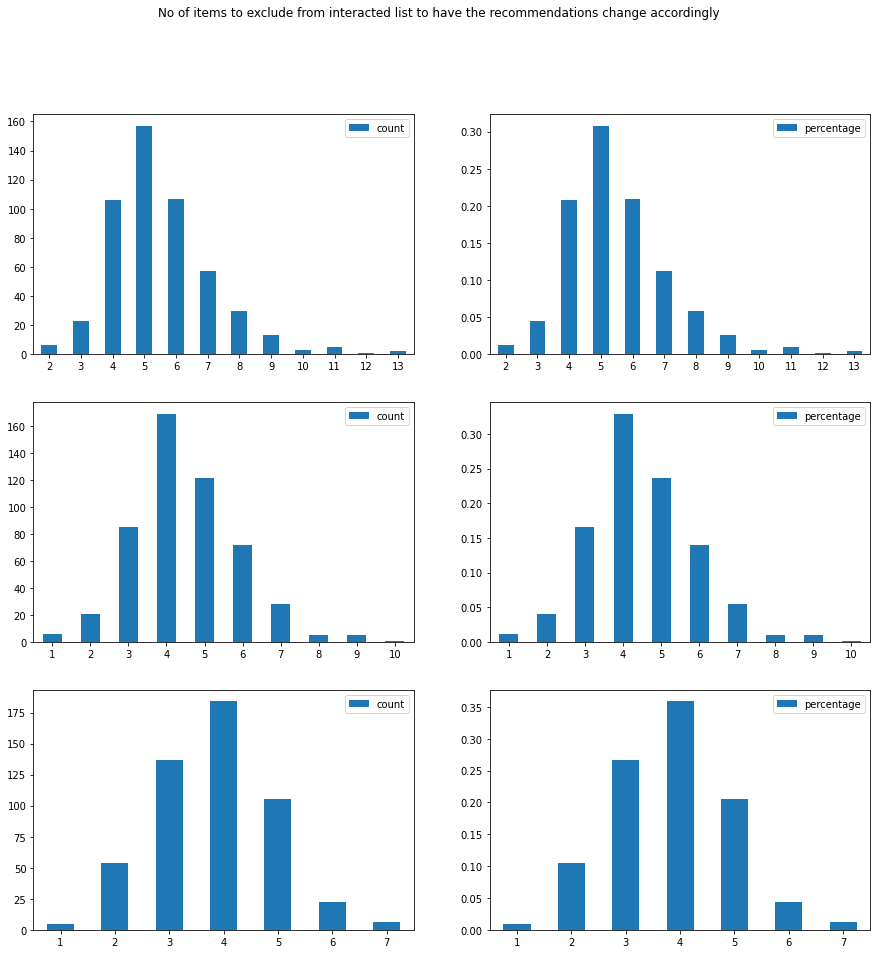

In [95]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [96]:
from collections import Counter


cnt = dict.fromkeys(best_cfs.keys())
non_solvable_cases = dict.fromkeys(best_cfs.keys())
counter = dict.fromkeys(best_cfs.keys())
for key, values in best_cfs.items():    
    cnt[key] = []
    non_solvable_cases[key] = []
    counter[key] = 0

    total_data = []
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10 : 
                non_solvable_cases[key].append(rec.user_id)
                total_data.append(rec.pos)

            counter[key] += 1
    
    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'Percentage of satisfied constraints')

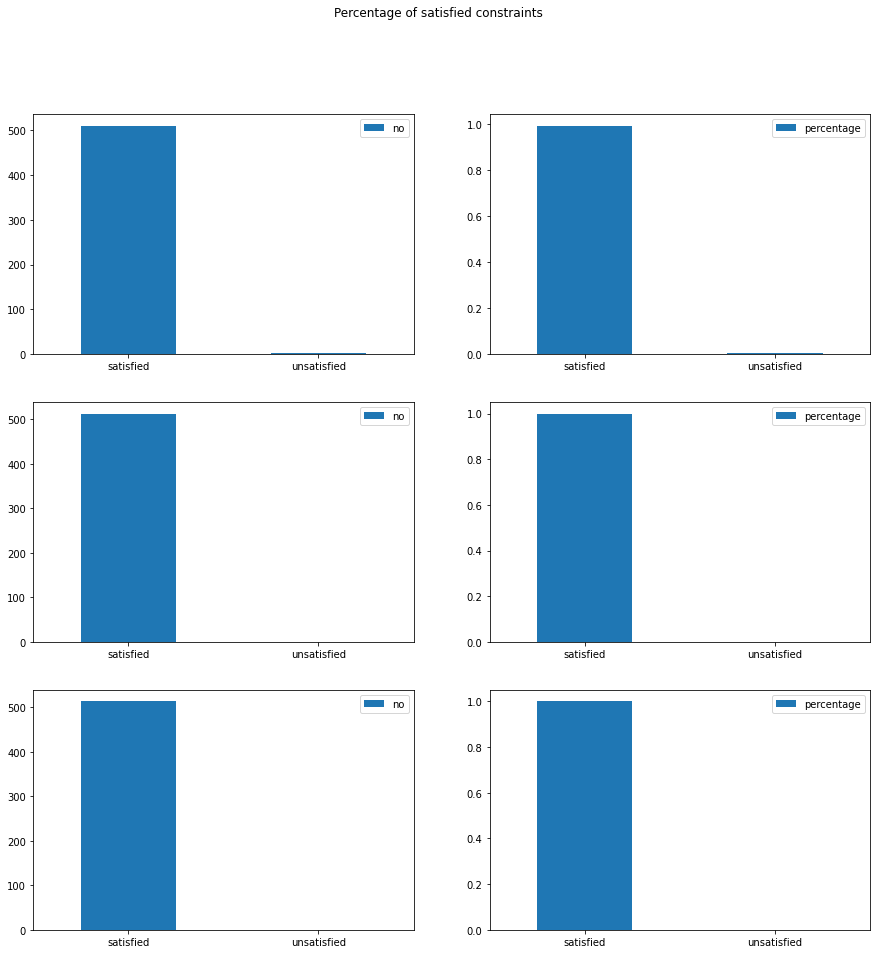

In [99]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))


df = pd.DataFrame([counter[3] - len(non_solvable_cases[3]), len(non_solvable_cases[3])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame([counter[5] - len(non_solvable_cases[5]), len(non_solvable_cases[5])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame([counter[7] - len(non_solvable_cases[7]), len(non_solvable_cases[7])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Percentage of satisfied constraints')

Text(0.5, 0.98, 'Position of not achieved cases')

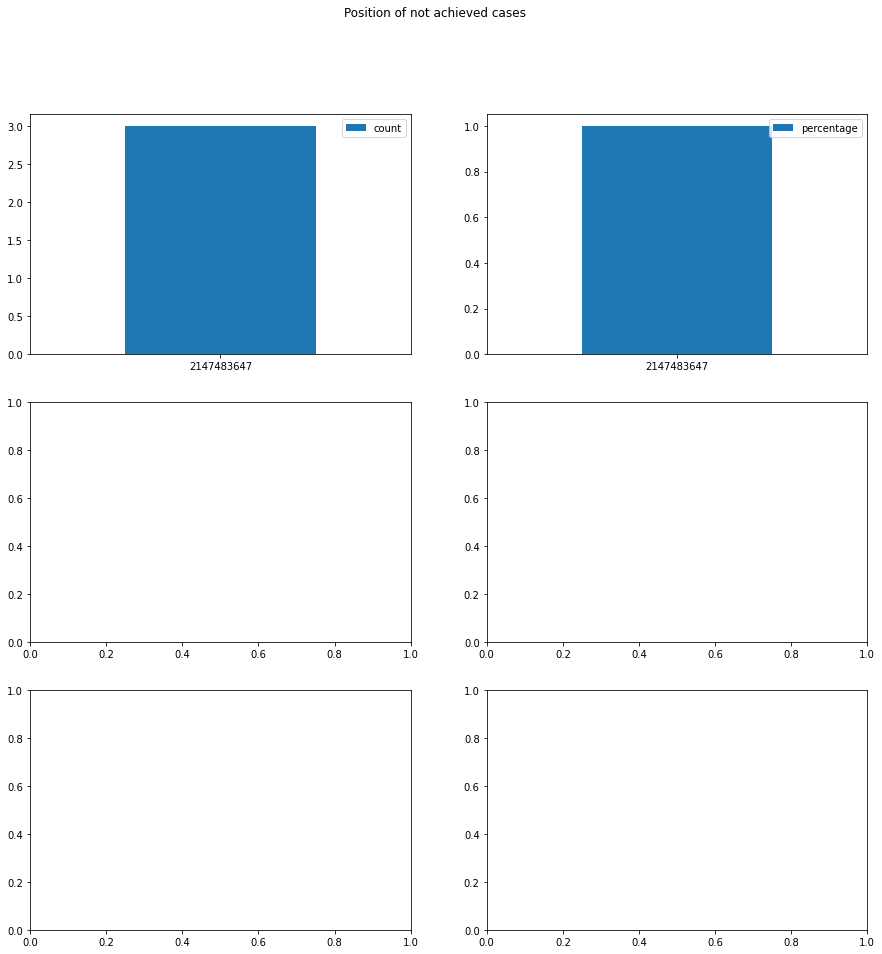

In [98]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))

if cnt[3]:
    df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

if cnt[5]:
    df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

if cnt[7]:
    df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Position of not achieved cases')

## **Most Similar** strategy

In [25]:
best_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='most_sim', budget=500)

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [02:34,  7.74s/it]              

target position loop: 30it [05:09, 10.06s/it]

target position loop: 30it [07:44, 15.49s/it]


In [27]:
from collections import Counter


cnt = dict.fromkeys(best_cfs.keys())
non_solvable_cases = dict.fromkeys(best_cfs.keys())
for key, values in best_cfs.items():
    total_data = []
    cnt[key] = []
    non_solvable_cases[key] = []
    
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10: 
                non_solvable_cases[key].append(rec.user_id)
                continue

            total_data.append(rec.cfs_dist)

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

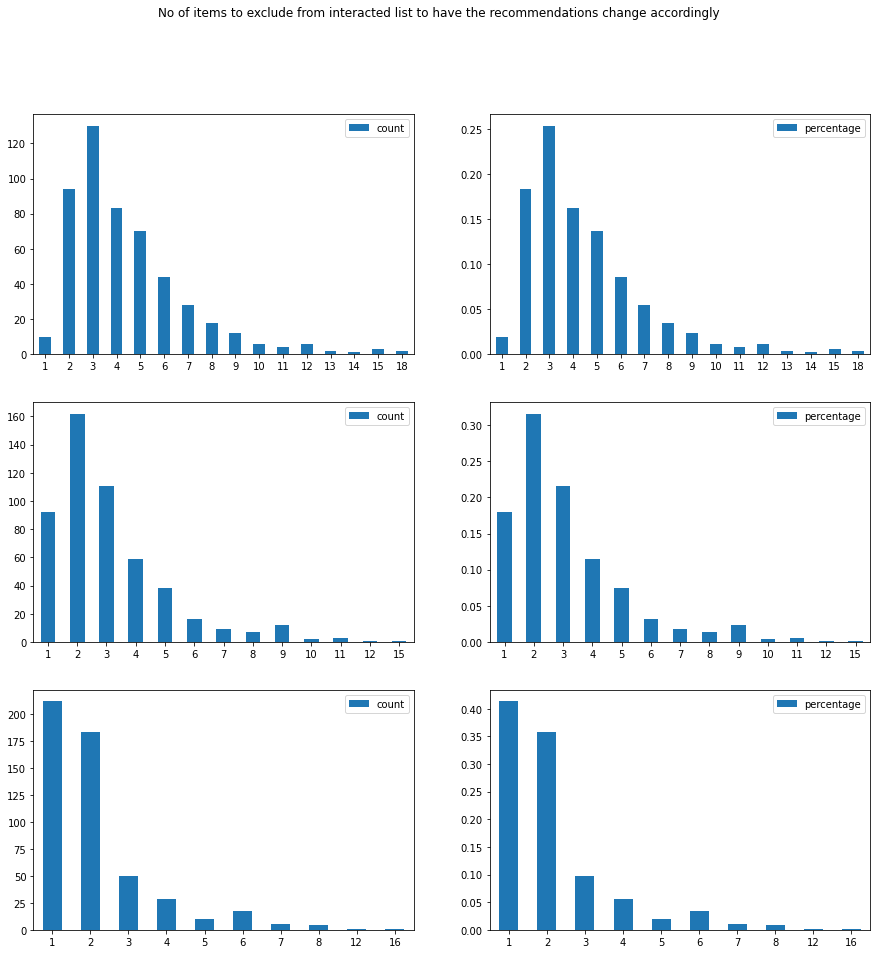

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [29]:
from collections import Counter


cnt = dict.fromkeys(best_cfs.keys())
non_solvable_cases = dict.fromkeys(best_cfs.keys())
counter = dict.fromkeys(best_cfs.keys())
for key, values in best_cfs.items():    
    cnt[key] = []
    non_solvable_cases[key] = []
    counter[key] = 0

    total_data = []
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10 : 
                non_solvable_cases[key].append(rec.user_id)
                total_data.append(rec.pos)

            counter[key] += 1
    
    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'Percentage of satisfied constraints')

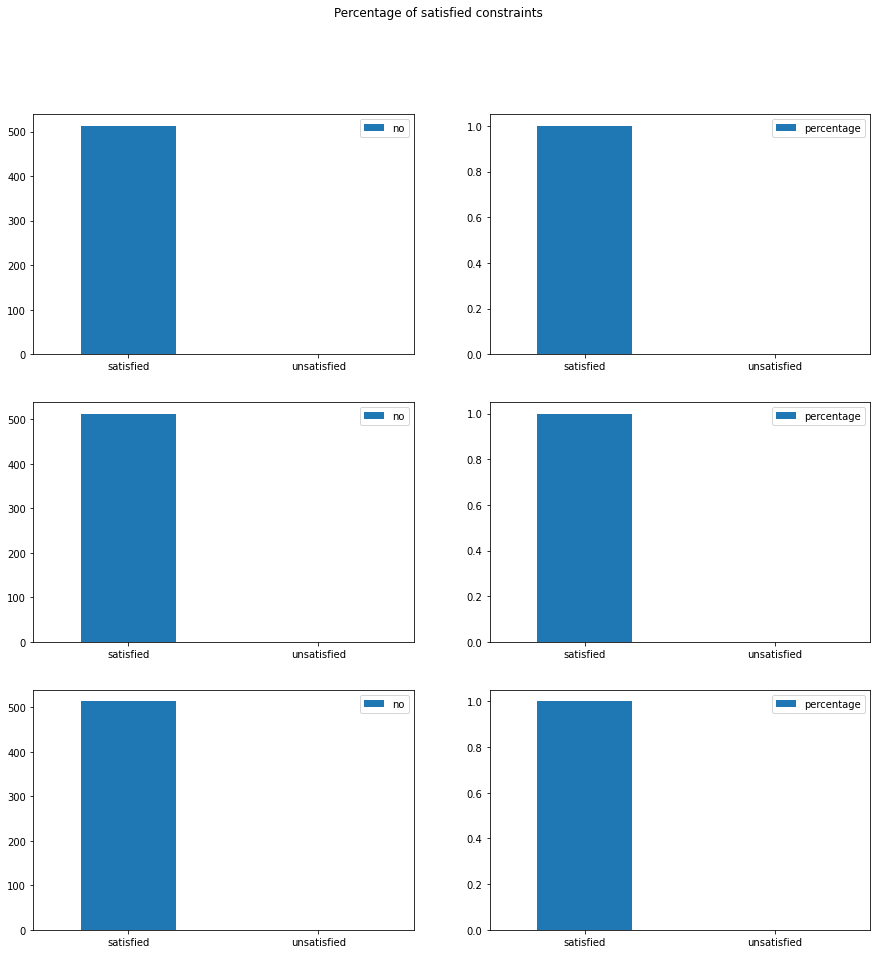

In [30]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))


df = pd.DataFrame([counter[3] - len(non_solvable_cases[3]), len(non_solvable_cases[3])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame([counter[5] - len(non_solvable_cases[5]), len(non_solvable_cases[5])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame([counter[7] - len(non_solvable_cases[7]), len(non_solvable_cases[7])],  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df/df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Percentage of satisfied constraints')

Text(0.5, 0.98, 'Position of not achieved cases')

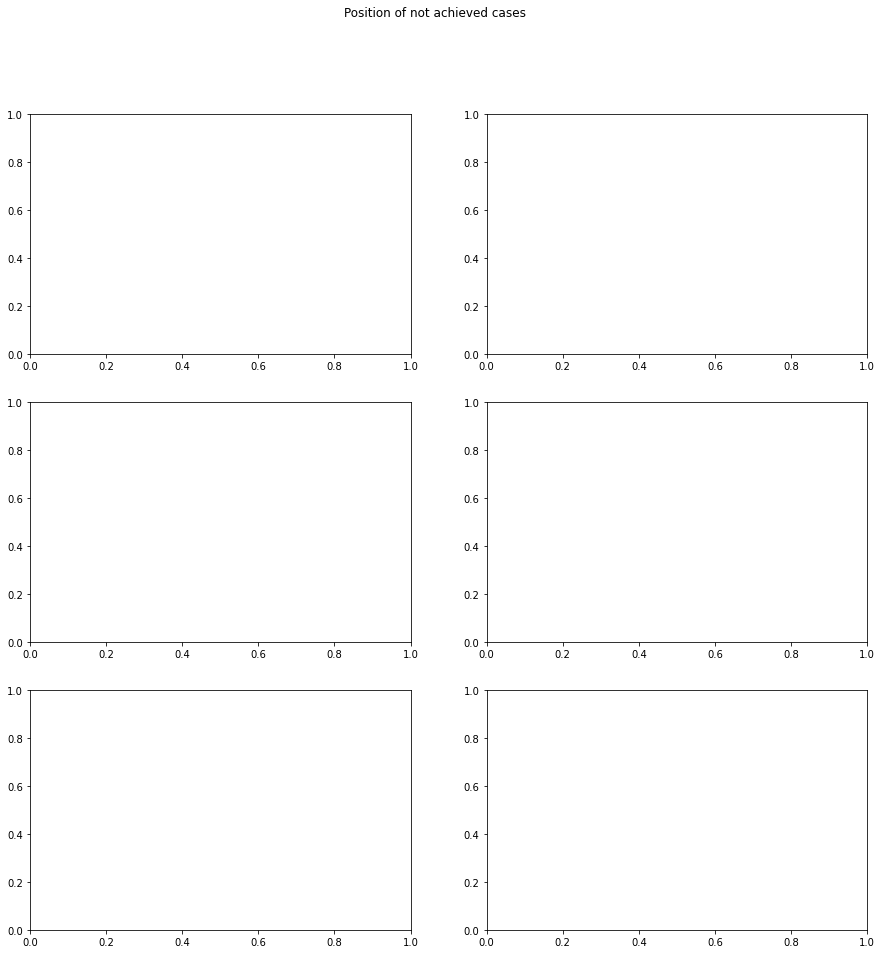

In [31]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))

if cnt[3]:
    df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

if cnt[5]:
    df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

if cnt[7]:
    df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Position of not achieved cases')